<a href="https://colab.research.google.com/github/J-oyin/Dr.-Jimoh-Analysis/blob/main/Sucrose_splash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

In [73]:
data = pd.read_excel("Dr.J_ST.xlsx")

In [74]:
data.head()

,S/N,Group,Sucrose_splash,conditions,Subject
0,1,Healthy,41,baseline,RC1
1,2,Healthy,47,baseline,RC2
2,3,Healthy,25,baseline,RC3
3,4,Healthy,35,baseline,RC4
4,5,Healthy,42,baseline,RC5


In [75]:
stat, p = shapiro(data['Sucrose_splash'])
print(f"Shapiro-Wilk Test: stat={stat:.3f}, p={p:.3f}")

if p > 0.05:
    print("Data is normally distributed")
else:
    print("Data is NOT normally distributed")


Shapiro-Wilk Test: stat=0.977, p=0.024
Data is NOT normally distributed


In [76]:
from scipy.stats import levene

grouped = [data[data['Group']==grp]['Sucrose_splash'].values for grp in
           ['Healthy', 'Resilient', 'S/DW', 'S/RG108', 'S/Esc',
            'S/LASA', 'S/LASA+ESC', 'S/HASA', 'S/HASA+ESC']]

stat, p = levene(*grouped)
print(f"Levene Test: stat={stat:.3f}, p={p:.3f}")

if p > 0.05:
    print("Variances are homogeneous across groups")
else:
    print("Variances are NOT homogeneous across groups")


Levene Test: stat=nan, p=nan
Variances are NOT homogeneous across groups


/tmp/ipython-input-2082092359.py:7: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = levene(*grouped)


In [77]:
df = data

In [78]:
df.head(10)

,S/N,Group,Sucrose_splash,conditions,Subject
0,1,Healthy,41,baseline,RC1
1,2,Healthy,47,baseline,RC2
2,3,Healthy,25,baseline,RC3
3,4,Healthy,35,baseline,RC4
4,5,Healthy,42,baseline,RC5
5,6,Healthy,67,post.indt,RC1
6,7,Healthy,57,post.indt,RC2
7,8,Healthy,45,post.indt,RC3
8,9,Healthy,52,post.indt,RC4
9,10,Healthy,55,post.indt,RC5


In [79]:
from scipy.stats import friedmanchisquare

# Create an empty list to collect results
results = []

# Loop over each group and run the Friedman test
for grp, data in df.groupby('Group'):
    # Pivot data so each condition becomes a column (subjects as rows)
    pivot = data.pivot(index='Subject', columns='conditions', values='Sucrose_splash')

    # Ensure conditions are in correct order
    pivot = pivot[['baseline', 'post.indt', 'post.tret']]

    # Run Friedman test
    stat, p = friedmanchisquare(pivot['baseline'], pivot['post.indt'], pivot['post.tret'])

    # Save results
    results.append({'Group': grp, 'Chi-square': stat, 'p-value': p})

# Convert results to dataframe
friedman_results = pd.DataFrame(results)
print(friedman_results)


        Group  Chi-square   p-value
0     Healthy    6.400000  0.040762
1   Resilient    5.200000  0.074274
2        S/DW    1.200000  0.548812
3       S/Esc    5.200000  0.074274
4      S/HASA    7.600000  0.022371
5  S/HASA+Esc    5.200000  0.074274
6      S/LASA    0.400000  0.818731
7  S/LASA+Esc    8.315789  0.015640
8     S/RG108    0.736842  0.691826


In [80]:

# ------- choose outcome variable -------
dv = 'Sucrose_splash'   # change this to any measure you like

# ------- function to build the table -------
def make_desc_table(data, group_cols, dv):
    g = data.groupby(group_cols)[dv]

    desc = g.agg(
        N='count',
        Mean='mean',
        SD='std',
        SEM=lambda x: x.std(ddof=1) / np.sqrt(x.count()),
        Median='median',
        Q1=lambda x: x.quantile(0.25),
        Q3=lambda x: x.quantile(0.75),
        Min='min',
        Max='max'
    ).reset_index()

    # IQR
    desc['IQR'] = desc['Q3'] - desc['Q1']

    # round for manuscript
    num_cols = ['Mean', 'SD', 'SEM', 'Median', 'Q1', 'Q3', 'IQR', 'Min', 'Max']
    desc[num_cols] = desc[num_cols].round(2)

    # formatted columns often reported in papers
    desc['Mean ± SD'] = desc['Mean'].astype(str) + ' ± ' + desc['SD'].astype(str)
    desc['Median (IQR)'] = (
        desc['Median'].astype(str) + ' (' +
        desc['Q1'].astype(str) + '–' +
        desc['Q3'].astype(str) + ')'
    )

    # column order
    cols_order = (
        group_cols +
        ['N', 'Mean', 'SD', 'SEM', 'Mean ± SD',
         'Median', 'Q1', 'Q3', 'IQR', 'Median (IQR)', 'Min', 'Max']
    )
    desc = desc[cols_order]

    return desc

# ------- build table: per Group × Condition -------
group_cols = ['Group', 'conditions']   # change if you want only Group, etc.
desc_table = make_desc_table(df, group_cols, dv)

print(desc_table)

# ------- export to Excel -------
output_file = f"Descriptive_stats_{dv}.xlsx"
desc_table.to_excel(output_file, index=False)
print("Saved to:", output_file)


         Group conditions  N  Mean     SD    SEM     Mean ± SD  Median    Q1  \
0      Healthy   baseline  5  38.0   8.43   3.77   38.0 ± 8.43    41.0  35.0   
1      Healthy  post.indt  5  55.2   8.01   3.58   55.2 ± 8.01    55.0  52.0   
2      Healthy  post.tret  5  37.6  17.34   7.76  37.6 ± 17.34    43.0  42.0   
3    Resilient   baseline  5  27.0  23.29  10.42  27.0 ± 23.29    22.0  11.0   
4    Resilient  post.indt  5  60.6  21.74   9.72  60.6 ± 21.74    50.0  48.0   
5    Resilient  post.tret  5  23.2  17.50   7.83   23.2 ± 17.5    31.0   9.0   
6         S/DW   baseline  5  54.8  56.10  25.09   54.8 ± 56.1    50.0   0.0   
7         S/DW  post.indt  5  51.6  15.13   6.76  51.6 ± 15.13    47.0  40.0   
8         S/DW  post.tret  5  33.0  18.75   8.38  33.0 ± 18.75    30.0  18.0   
9        S/Esc   baseline  5  76.8  28.85  12.90  76.8 ± 28.85    65.0  57.0   
10       S/Esc  post.indt  5  33.8  18.79   8.40  33.8 ± 18.79    28.0  28.0   
11       S/Esc  post.tret  5  54.2  21.2

/tmp/ipython-input-1998548802.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


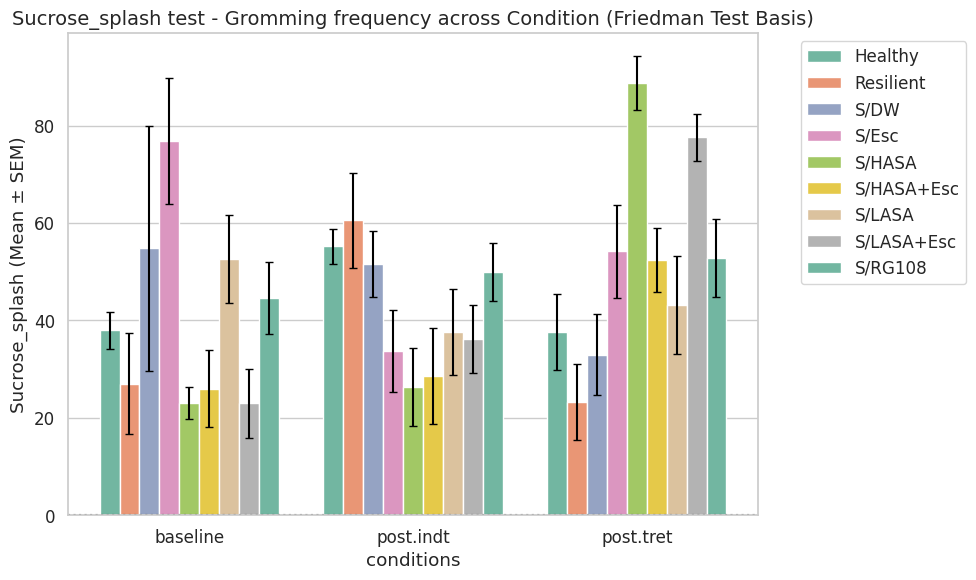

In [81]:

summary = (
    df.groupby(['Group', 'conditions'])['Sucrose_splash']
      .agg(['mean', 'sem'])
      .reset_index()
)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", font_scale=1.1)

# Create the barplot (mean values)
ax = sns.barplot(
    data=summary,
    x='conditions',
    y='mean',
    hue='Group',
    ci=None,  # we are providing our own SEM
    capsize=0.1,
    palette='Set2'
)

for i, row in summary.iterrows():
    group_index = list(summary['Group'].unique()).index(row['Group'])
    cond_index = list(summary['conditions'].unique()).index(row['conditions'])
    bar = ax.patches[i]
    x = bar.get_x() + bar.get_width()/2
    y = row['mean']
    plt.errorbar(x, y, yerr=row['sem'], fmt='none', ecolor='black', capsize=3)

plt.title("Sucrose_splash test - Gromming frequency across Condition (Friedman Test Basis)", fontsize=14)
plt.ylabel("Sucrose_splash (Mean ± SEM)")
plt.xlabel("conditions")
plt.axhline(color='k', ls=':')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
plt.tight_layout()
plt.show()


In [82]:
from scipy.stats import wilcoxon
import itertools

# Filter only the three groups
groups_of_interest = ['Healthy', 'S/HASA']
df_sub = df[df['Group'].isin(groups_of_interest)]


In [83]:
print(df['conditions'].unique())


['baseline' 'post.indt' 'post.tret']


In [84]:
data_group = df[df['Group'] == 'Healthy']
data_pivot = data_group.pivot(index='Subject', columns='conditions', values='Sucrose_splash')
print("Pivot columns:", data_pivot.columns)


Pivot columns: Index(['baseline', 'post.indt', 'post.tret'], dtype='object', name='conditions')


In [85]:
import itertools
import pandas as pd
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

results = []
groups_to_test = ['Healthy', 'S/HASA']

# Get all possible pairwise condition combinations
condition_pairs = list(itertools.combinations(df['conditions'].unique(), 2))

for g in groups_to_test:
    data_group = df[df['Group'] == g]

    # Pivot to wide format per subject
    data_pivot = data_group.pivot(index='Subject', columns='conditions', values='Sucrose_splash')

    raw_p = []          # store raw p-values for this group
    pair_labels = []    # store labels for Holm correction

    # Loop over pairs of conditions
    for cond1, cond2 in condition_pairs:
        if cond1 in data_pivot.columns and cond2 in data_pivot.columns:
            valid = data_pivot[[cond1, cond2]].dropna()

            if len(valid) > 0:
                stat, p = wilcoxon(valid[cond1], valid[cond2])

                raw_p.append(p)
                pair_labels.append((cond1, cond2))

            else:
                print(f"⚠️ Skipped {g}: insufficient data for {cond1} vs {cond2}")
        else:
            print(f"⚠️ Skipped {g}: missing {cond1} or {cond2}")

    # Apply Holm correction for this group
    if len(raw_p) > 0:
        reject, p_corr, _, _ = multipletests(raw_p, method='holm')

        # Save results
        for (cond1, cond2), stat_p, p_unc, p_adj, sig in zip(
            pair_labels,
            raw_p,
            raw_p,
            p_corr,
            reject
        ):
            results.append({
                'Group': g,
                'Comparison': f'{cond1} vs {cond2}',
                'p-value': p_unc,
                'p-Holm': p_adj,
                'Significant': sig
            })

# Final table
posthoc_df = pd.DataFrame(results)
print(posthoc_df)


     Group              Comparison  p-value  p-Holm  Significant
0  Healthy   baseline vs post.indt   0.0625  0.1875        False
1  Healthy   baseline vs post.tret   0.5625  0.5625        False
2  Healthy  post.indt vs post.tret   0.1250  0.2500        False
3   S/HASA   baseline vs post.indt   1.0000  1.0000        False
4   S/HASA   baseline vs post.tret   0.0625  0.1875        False
5   S/HASA  post.indt vs post.tret   0.0625  0.1875        False


In [86]:
import itertools
from scipy.stats import wilcoxon

condition_pairs = list(itertools.combinations(df['conditions'].unique(), 2))
results = []

for g in ['Healthy', 'S/HASA']:
    data_group = df[df['Group'] == g]
    data_pivot = data_group.pivot(index='Subject', columns='conditions', values='Sucrose_splash')

    for cond1, cond2 in condition_pairs:
        if cond1 in data_pivot.columns and cond2 in data_pivot.columns:
            valid = data_pivot[[cond1, cond2]].dropna()
            stat, p = wilcoxon(valid[cond1], valid[cond2])
            results.append({'Group': g, 'Comparison': f'{cond1} vs {cond2}', 'Statistic': stat, 'p-value': p})
        else:
            print(f"⚠️ Skipped {g}: missing {cond1} or {cond2}")

import pandas as pd
posthoc_df = pd.DataFrame(results)
print(posthoc_df)

     Group              Comparison  Statistic  p-value
0  Healthy   baseline vs post.indt        0.0   0.0625
1  Healthy   baseline vs post.tret        5.0   0.5625
2  Healthy  post.indt vs post.tret        1.0   0.1250
3   S/HASA   baseline vs post.indt        7.0   1.0000
4   S/HASA   baseline vs post.tret        0.0   0.0625
5   S/HASA  post.indt vs post.tret        0.0   0.0625


In [87]:
!pip install statannotations


Pairs used: []
P-values: []


/tmp/ipython-input-917230655.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.barplot(
/tmp/ipython-input-917230655.py:35: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.2}` instead.

  ax = sns.barplot(


ValueError: pairs are empty after parsing: original_pairs=[]
not in group_list=[('Healthy', 'baseline'), ('Healthy', 'post.indt'), ('Healthy', 'post.tret'), ('S/HASA', 'baseline'), ('S/HASA', 'post.indt'), ('S/HASA', 'post.tret')]

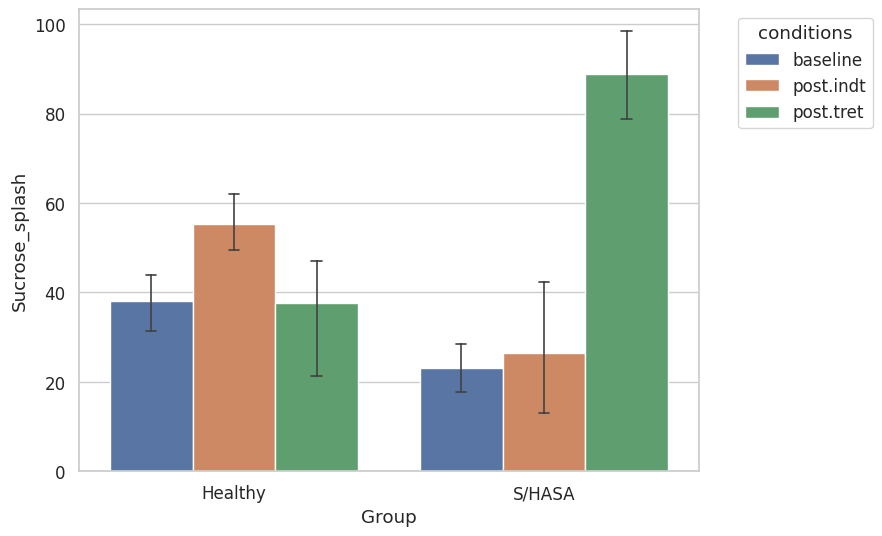

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

# ── 0. If you have Holm-corrected p-values, set the column name here ──
p_col = 'p-Holm' if 'p-Holm' in posthoc_df.columns else 'p-value'

# ── 1. Split "baseline vs post.indt" into 2 condition columns ──
posthoc_df[['cond1', 'cond2']] = posthoc_df['Comparison'].str.split(' vs ', expand=True)

# ── 2. Keep only significant comparisons (you can change alpha if you like) ──
alpha = 0.05
sig_df = posthoc_df[posthoc_df[p_col] < alpha]

# ── 3. Build `pairs` and `p_values` for statannotations ──
pairs = []
p_values = []

for _, row in sig_df.iterrows():
    g = row['Group']
    c1 = row['cond1']
    c2 = row['cond2']

    # pair format is: ((x, hue), (x, hue))
    pairs.append(((g, c1), (g, c2)))
    p_values.append(row[p_col])

print("Pairs used:", pairs)
print("P-values:", p_values)

# ── 4. Plot the bars ──
plot_df = df[df['Group'].isin(['Healthy', 'S/HASA'])]

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=plot_df,
    x='Group', y='Sucrose_splash', hue='conditions',
    ci=95, capsize=0.1, errwidth=1.2
)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='conditions')

# ── 5. Add significance stars from the pairs + p_values ──
annot = Annotator(
    ax,
    pairs,
    data=plot_df,
    x='Group',
    y='Sucrose_splash',
    hue='conditions'
)
annot.configure(test=None, text_format='star', loc='inside', verbose=2)
annot.set_pvalues(p_values)
annot.annotate()

plt.title('Post Hoc Comparison Across Conditions')
plt.xlabel('Group')
plt.ylabel('Behavioral Measure (mean ± CI)')
plt.tight_layout()
plt.show()
